In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from torchvision.transforms import Resize, InterpolationMode, ToPILImage, RandomCrop
import torchmetrics
from torchmetrics import JaccardIndex, Precision, Recall, F1Score
from src.callbacks.SaveRandomImagesCallback import SaveRandomImagesCallback
from src.callbacks.SaveTestPreds import SaveTestPreds
import segmentation_models_pytorch as smp

from src.evaluation.evaluate_result import evaluate_result
from src.datasets.UAVidSemanticSegmentationDataset import (
    UAVidSemanticSegmentationDataset,
)
from src.utils import view_and_save_images_shapes

d:\__repos\aerial_segmentation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare environment

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if you get some cryptic CUDA error, set device to "cpu" and try again

# DEBUG
# device = torch.device("cpu")
print(device)

cuda


In [4]:
VAL_SIZE = 0.2
BATCH_SIZE = 2
SEED = 42
SAVE_VAL_DIR = "outputs/UAVid/val"
SAVE_TEST_DIR = "outputs/UAVid/test"
UAVID_DATASET_PATH = "data/UAVidSemanticSegmentationDataset"
IMAGE_WIDTH = 1024
IMAGE_HEIGHT = 576

## Prepare data

In [5]:
train_dataset = UAVidSemanticSegmentationDataset(
    UAVID_DATASET_PATH,
    split="train",
)
print(len(train_dataset))

200


In [6]:
val_dataset = UAVidSemanticSegmentationDataset(
    UAVID_DATASET_PATH,
    split="valid",
)
print(len(val_dataset))

70


In [7]:
test_dataset = UAVidSemanticSegmentationDataset(
    UAVID_DATASET_PATH,
    split="test",
)
print(len(test_dataset))

10


### Train, val, test split

In [8]:
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)

### Sanity check

... for this to make sense don't use any transforms in datasets

In [9]:
# view_and_save_images_shapes(train_loader, 'uavid_train_images_shapes', verbose=True)

In [10]:
# view_and_save_images_shapes(val_loader, 'uavid_val_images_shapes')

In [11]:
# view_and_save_images_shapes(test_loader, 'uavid_test_images_shapes', verbose=True, train=False)

torch.Size([2, 1, 2160, 3840])
{0: 3019113, 1: 5746917, 2: 2635734, 3: 647787, 4: 3230247, 5: 599314, 6: 126017, 7: 583671}


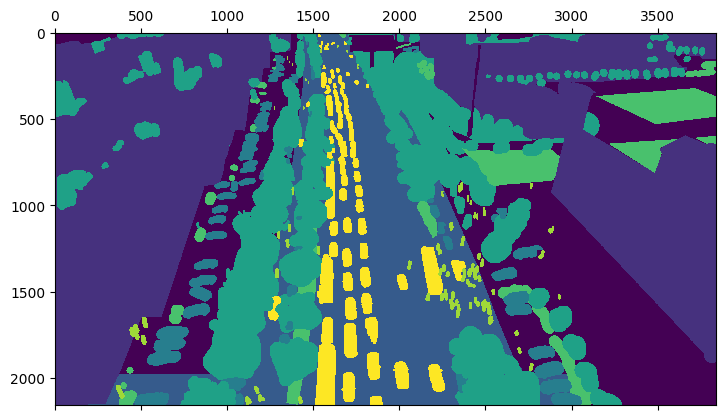

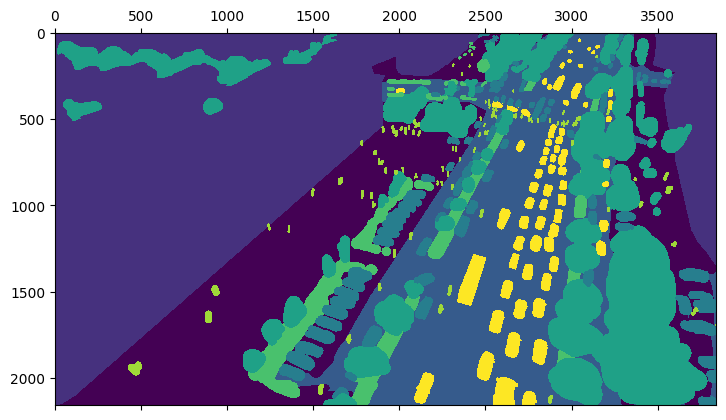

torch.Size([2, 1, 2160, 3840])
{0: 3093980, 1: 6452926, 2: 2645183, 3: 731678, 4: 2603935, 5: 525182, 6: 133935, 7: 401981}


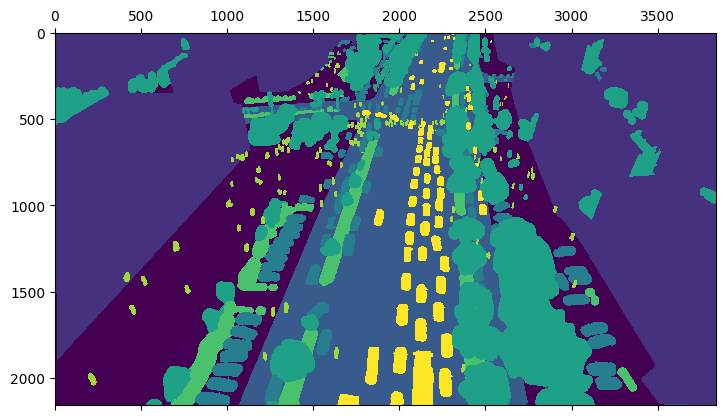

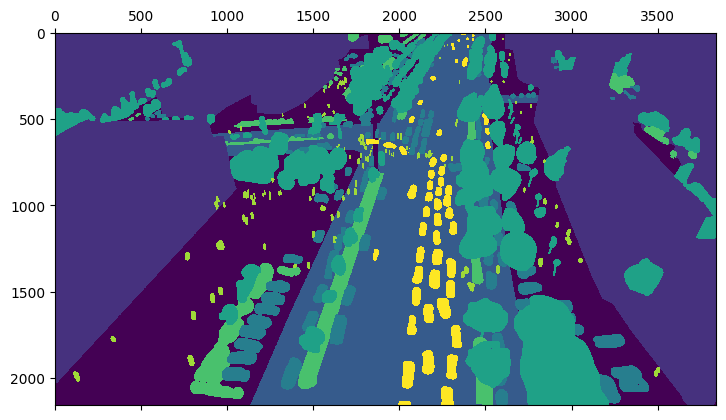

torch.Size([2, 1, 2160, 3840])
{0: 2529354, 1: 7509080, 2: 2735509, 3: 404308, 4: 2640811, 5: 213257, 6: 120988, 7: 435493}


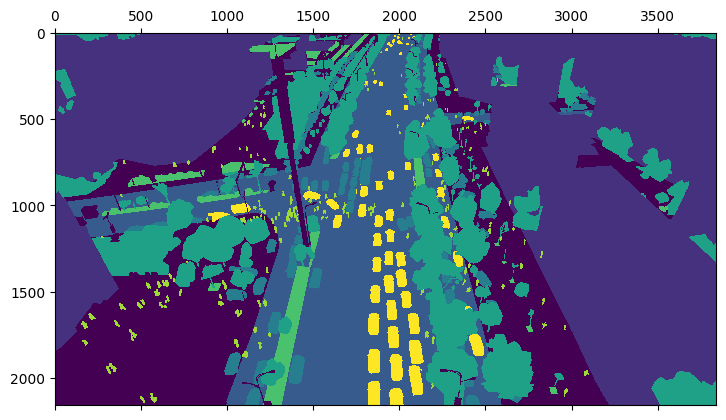

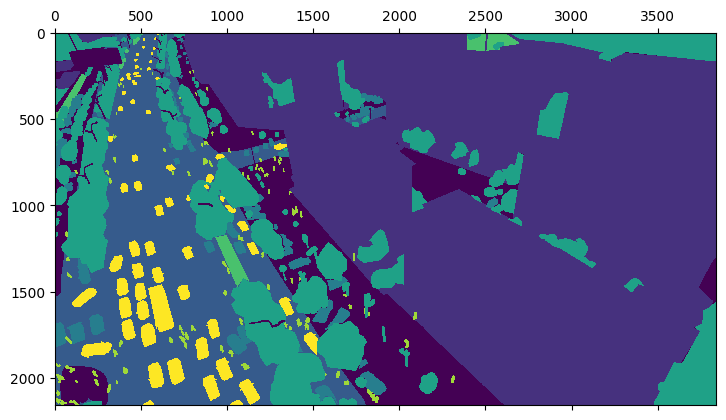

torch.Size([2, 1, 2160, 3840])
{0: 2640496, 1: 6683790, 2: 3259008, 3: 618755, 4: 2576636, 5: 377077, 6: 122658, 7: 310380}


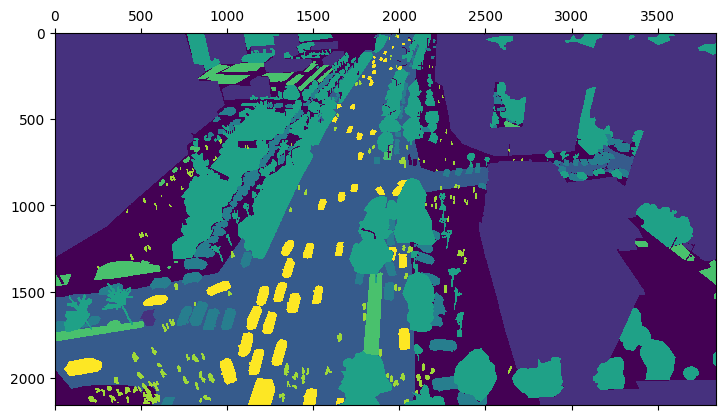

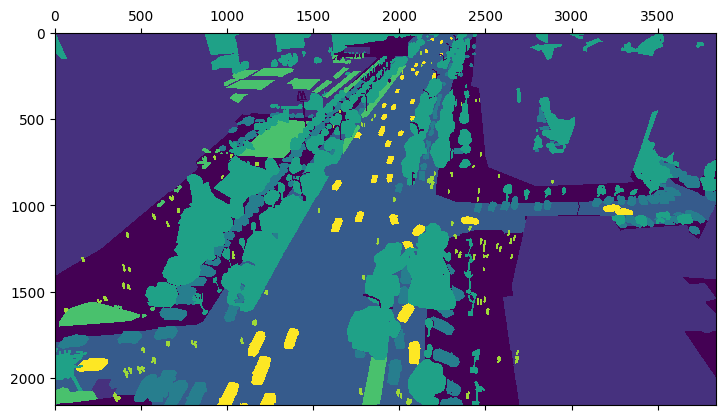

torch.Size([2, 1, 2160, 3840])
{0: 2550889, 1: 4730004, 2: 4856289, 3: 495932, 4: 3178828, 5: 427311, 6: 117554, 7: 231993}


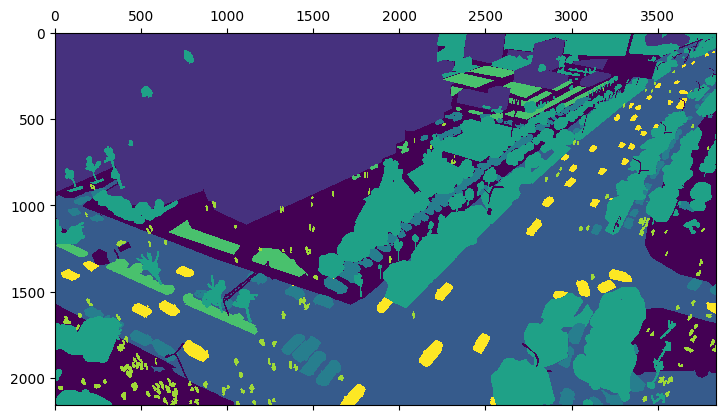

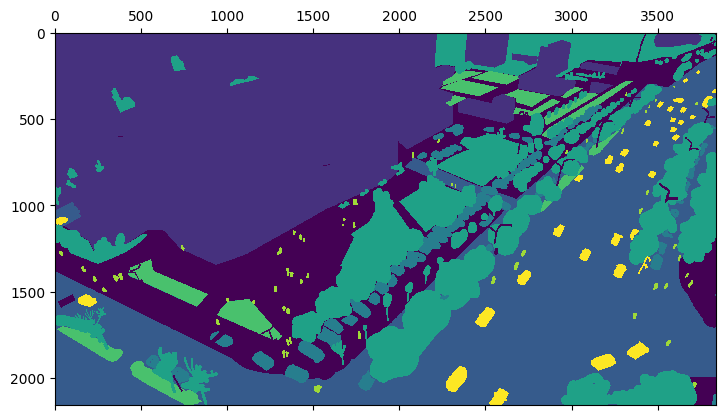

torch.Size([2, 1, 2160, 3840])
{0: 1702904, 1: 2196416, 2: 5253461, 3: 245324, 4: 2955864, 5: 3739648, 6: 9769, 7: 485414}


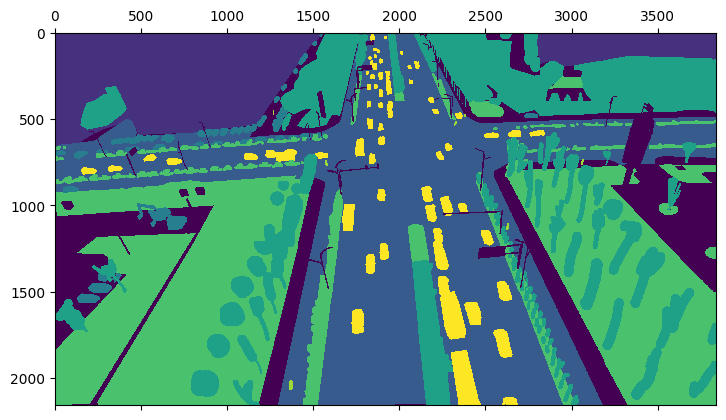

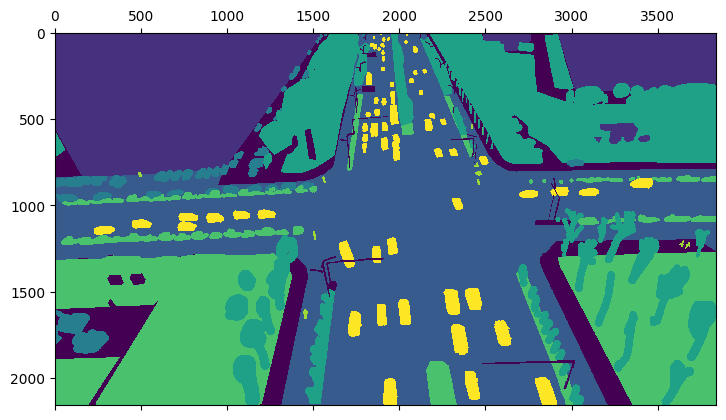

torch.Size([2, 1, 2160, 3840])
{0: 1466763, 1: 2847807, 2: 6951913, 3: 235340, 4: 3788775, 5: 912867, 6: 9337, 7: 375998}


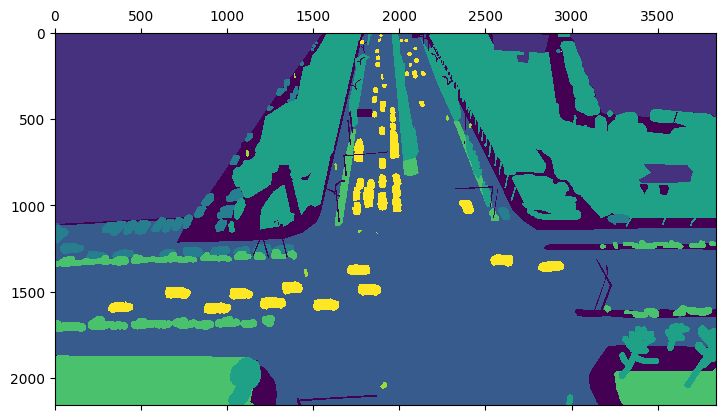

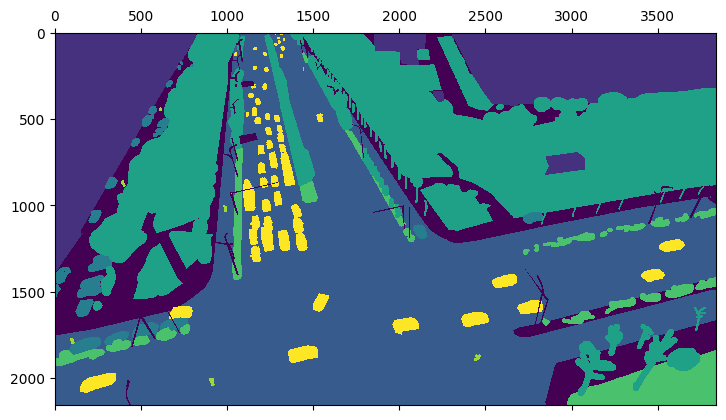

torch.Size([2, 1, 2160, 3840])
{0: 2895849, 1: 2031841, 2: 5166649, 3: 58772, 4: 3667274, 5: 2387429, 6: 7167, 7: 373819}


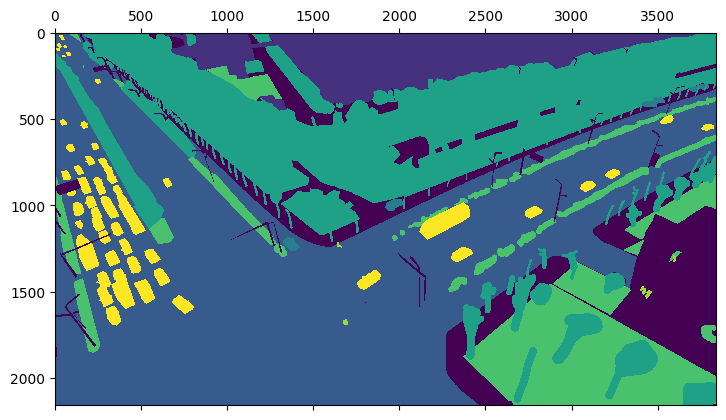

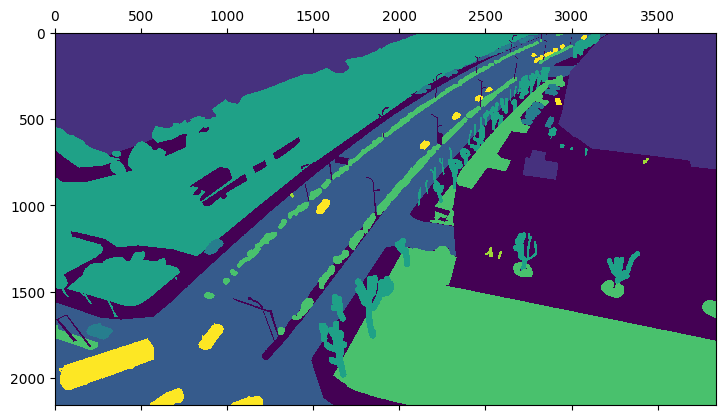

torch.Size([2, 1, 2160, 3840])
{0: 5852698, 1: 3733788, 2: 2165758, 3: 107025, 4: 2637777, 5: 1979464, 6: 13993, 7: 98297}


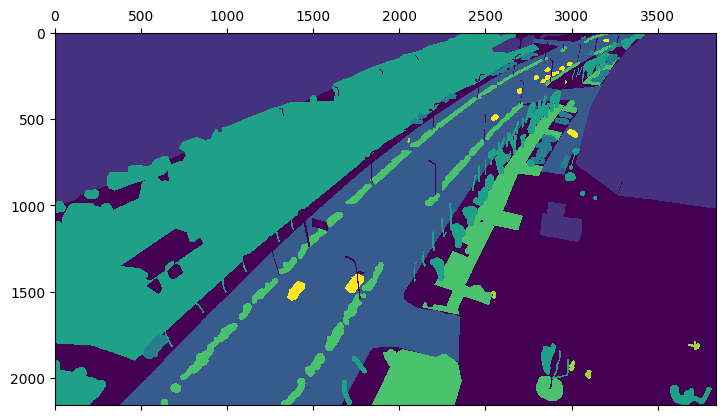

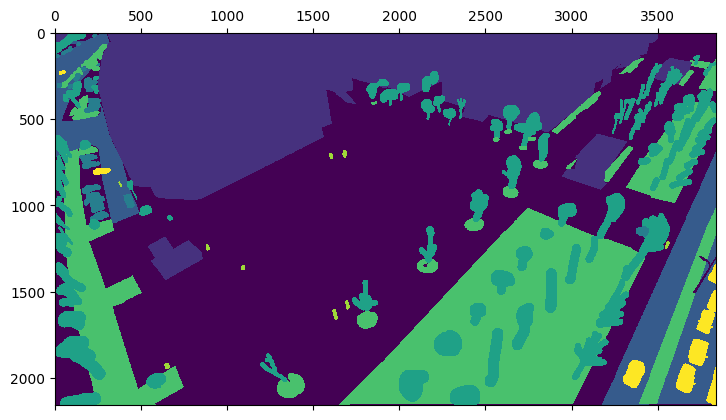

torch.Size([2, 1, 2160, 3840])
{0: 4420383, 1: 3009003, 2: 3370068, 3: 14056, 4: 2665230, 5: 2708602, 6: 10912, 7: 390546}


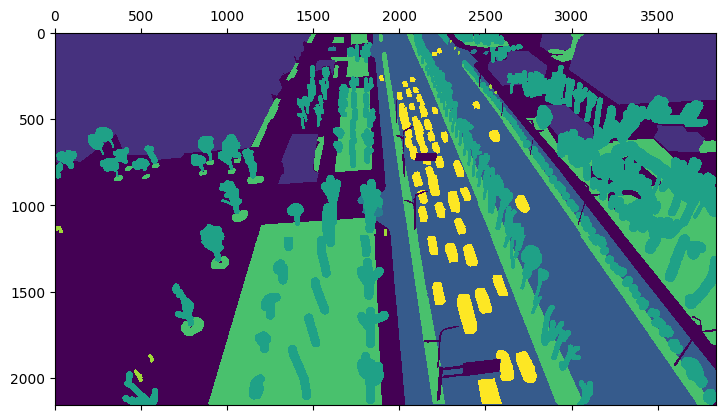

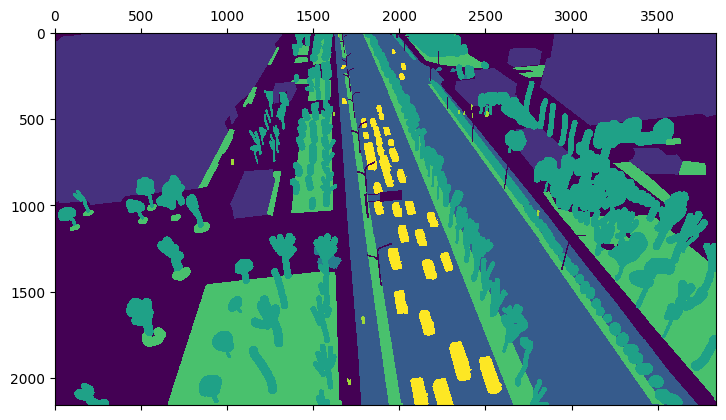

torch.Size([2, 1, 2160, 4096])
{0: 1564117, 1: 3530149, 2: 2133044, 3: 18669, 4: 8862934, 5: 1147896, 6: 13192, 7: 424719}


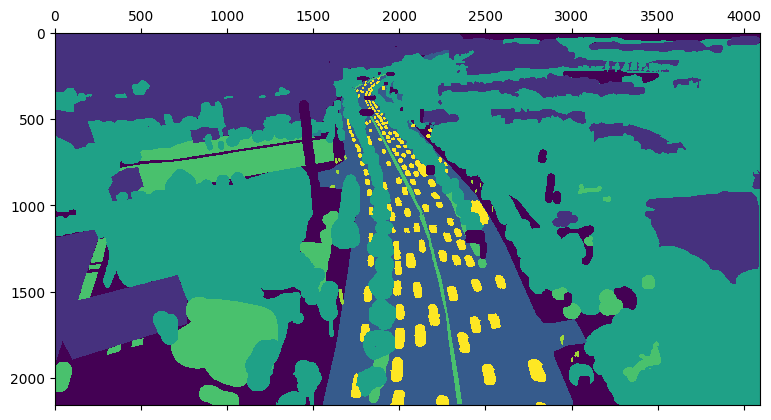

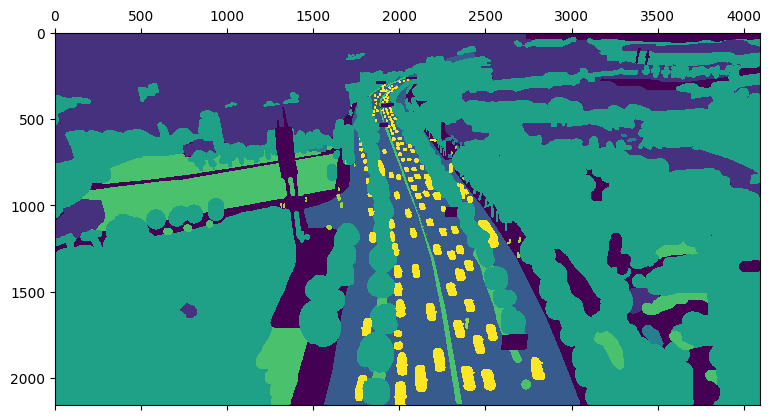

In [14]:
n = 0
for images, masks in train_loader:
    # print(images.shape)
    print(masks.shape)
    unique, counts = np.unique(masks, return_counts=True)
    print(dict(zip(unique, counts)))
    plt.matshow(masks[0].squeeze())
    plt.show()
    plt.matshow(masks[1].squeeze())
    plt.show()

    if n == 10:
        break

    n += 1

In [ ]:
to_pil_transform = ToPILImage()

In [ ]:
if BATCH_SIZE == 1:
    img = to_pil_transform(images.squeeze())

In [ ]:
# img.show()

In [ ]:
if BATCH_SIZE == 1:
    msk = to_pil_transform(masks.squeeze())

In [ ]:
# msk.show()

## Basic training loop

In [ ]:
import gc

gc.collect()

In [ ]:
torch.cuda.empty_cache()

# Training module

In [ ]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        super(SegmentationModel, self).__init__()

        self.model = model
        self.learning_rate = learning_rate

        self.criterion = smp.losses.JaccardLoss(mode="multiclass", from_logits=False)
        self.train_iou = JaccardIndex(num_classes=8, task="multiclass")
        self.val_iou = JaccardIndex(num_classes=8, task="multiclass")

        # self.save_hyperparameters()

    def forward(self, x):
        output = self.model(x.to(device))
        return output

    def training_step(self, batch, batch_idx):
        images, masks = batch
        preds = self(images)
        loss = self.criterion(preds, masks.squeeze(1).long())

        self.log("train_loss", loss, on_epoch=True, on_step=True)
        self.log(
            "train_iou",
            self.train_iou(preds, masks.squeeze(1)),
            on_epoch=True,
            on_step=True,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        preds = self(images)
        loss = self.criterion(preds, masks.squeeze(1).long())

        self.log("val_loss", loss, on_epoch=True, on_step=True)
        self.log(
            "val_iou",
            self.val_iou(preds, masks.squeeze(1)),
            on_epoch=True,
            on_step=True,
        )

        return loss

    def test_step(self, batch, batch_idx):
        # just here to activate the test_epoch_end
        # callback SaveTestPreds starts on_test_epoch_end
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

### Model selection

In [ ]:
model = smp.Unet(
    encoder_name="resnet18",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=8,  # model output channels (number of classes in your dataset)
    activation="softmax",
).to(device)

In [ ]:
# model = smp.UnetPlusPlus(
#     encoder_name="resnet18",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,  # model output channels (number of classes in your dataset)
# ).to(device)

In [ ]:
# model = smp.DeepLabV3(
#     encoder_name="resnet18",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,
# ).to(device)

In [ ]:
# model = smp.DeepLabV3Plus(
#     encoder_name="resnet18",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,
# ).to(device)

In [ ]:
segmentation_model = SegmentationModel(model)

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", save_top_k=-1, mode="min"
)

In [ ]:
logger = CSVLogger("lightning_logs", name="uavid_segmentation_model")

In [ ]:
save_callback = SaveRandomImagesCallback(save_dir=SAVE_VAL_DIR)

# Dubai test dataset is also labeled
# so we can use different logic for test set evaluation
save_test_preds_callback = SaveTestPreds(save_dir=SAVE_TEST_DIR)

early_stopping_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [ ]:
trainer = pl.Trainer(
    max_epochs=1,
    log_every_n_steps=10,
    callbacks=[
        model_checkpoint_callback,
        save_callback,
        save_test_preds_callback,
        early_stopping_callback,
    ],
    logger=logger,
)

# DEBUG
# trainer = pl.Trainer(
#     max_epochs=1,
#     callbacks=[model_checkpoint_callback, save_callback],
#     logger=logger,
#     accelerator="cpu"
#     )

In [ ]:
trainer.fit(
    segmentation_model, train_dataloaders=train_loader, val_dataloaders=val_loader
)

In [ ]:
trainer.test(ckpt_path="best", dataloaders=test_loader)